# PyWavelets 

In this juypter notebook, we will be using the pre-defined pywavelets library to perform 2D and 3D wavelet transforms on Choas dataset. This will allow us to understand how outputs should look like and how to interpret them. Also being used for comparison with our own cpp implementation of 2D and 3D wavelet transforms.

### Imports

In [68]:
# Usual imports
import matplotlib.pyplot as plt
import numpy as np
import os

# Importing the PyWavelets library
import pywt
import pydicom

### 2D DWT

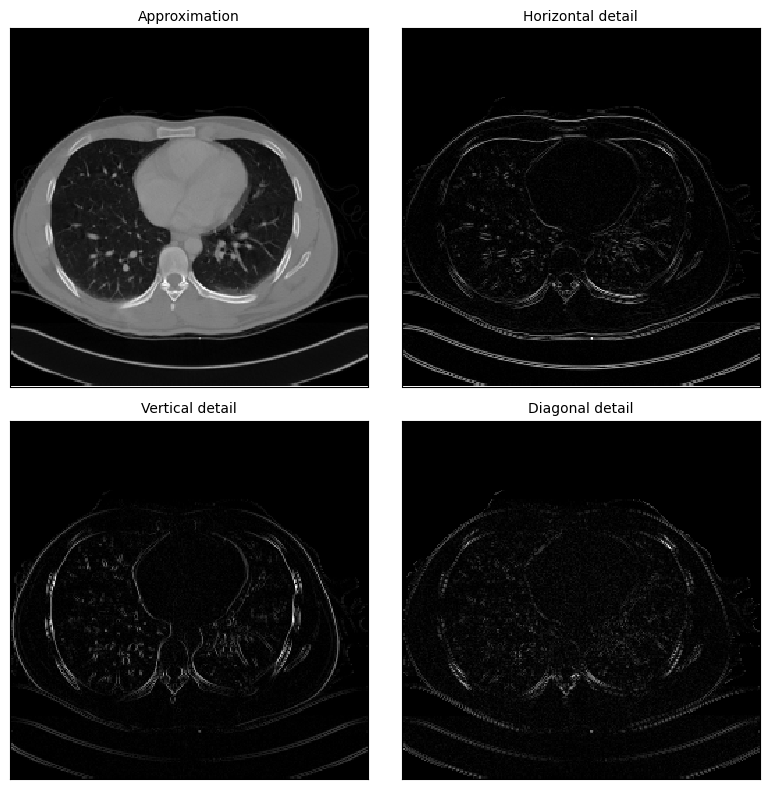

In [69]:
# DCM images directory
dcm_dir = "/home/grahampelle/cce3015/assignment-1/CHAOS-Test-Sets/CT/3/DICOM_anon/"

# Loading a single image from the directory
img = pydicom.dcmread(dcm_dir + "i0000,0000b.dcm").pixel_array

def wavelet_2d(img):
    # 2D Discrete Wavelet Transform on the image and plot the approximation and detail results
    titles = ['Approximation', 'Horizontal detail', 'Vertical detail', 'Diagonal detail']
    coeffs2 = pywt.dwt2(img, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    # Take the absolute value of the coefficients to make them easier to visualize
    LL, LH, HL, HH = np.abs(LL), np.abs(LH), np.abs(HL), np.abs(HH)
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for i, (a, title) in enumerate(zip([LL, LH, HL, HH], titles)):
        ax = axes[i // 2, i % 2]
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

wavelet_2d(img)

### Multi-Level 2D DWT

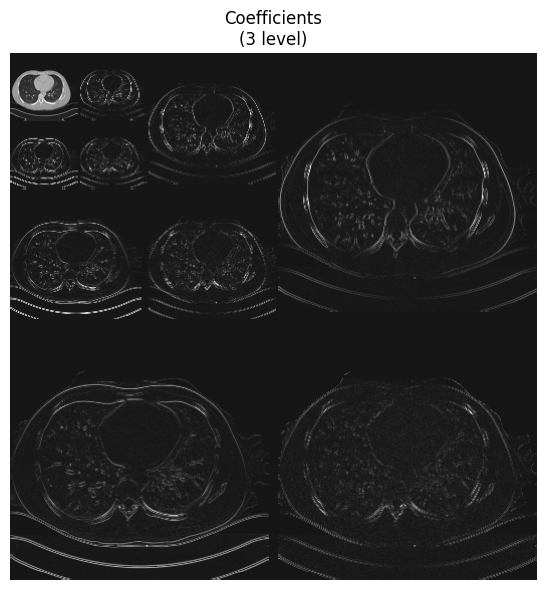

In [70]:
# Multi-level 2D Discrete Wavelet Transform
def wavelet_2d_multi(img, levels):
    # Compute the 2D DWT for the highest level
    coeffs = pywt.wavedec2(img, 'bior1.3', level=levels)

    # Take the absolute value of the coefficients to make them easier to visualize
    for i in range(1, len(coeffs)):
        coeffs[i] = [np.abs(detail) for detail in coeffs[i]]
    
    # Normalize each coefficient array independently for better visibility
    coeffs[0] /= np.abs(coeffs[0]).max()
    for i in range(1, len(coeffs)):
        coeffs[i] = [detail / np.abs(detail).max() for detail in coeffs[i]]
    
    
    # Convert the coefficients to a single array for visualization
    arr, _ = pywt.coeffs_to_array(coeffs)
    
    # Plot the coefficients of the highest decomposition level
    plt.figure(figsize=(6, 6))
    plt.imshow(arr, cmap=plt.cm.gray)
    plt.title(f'Coefficients\n({levels} level)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


wavelet_2d_multi(img, 3)

## 3D DWT

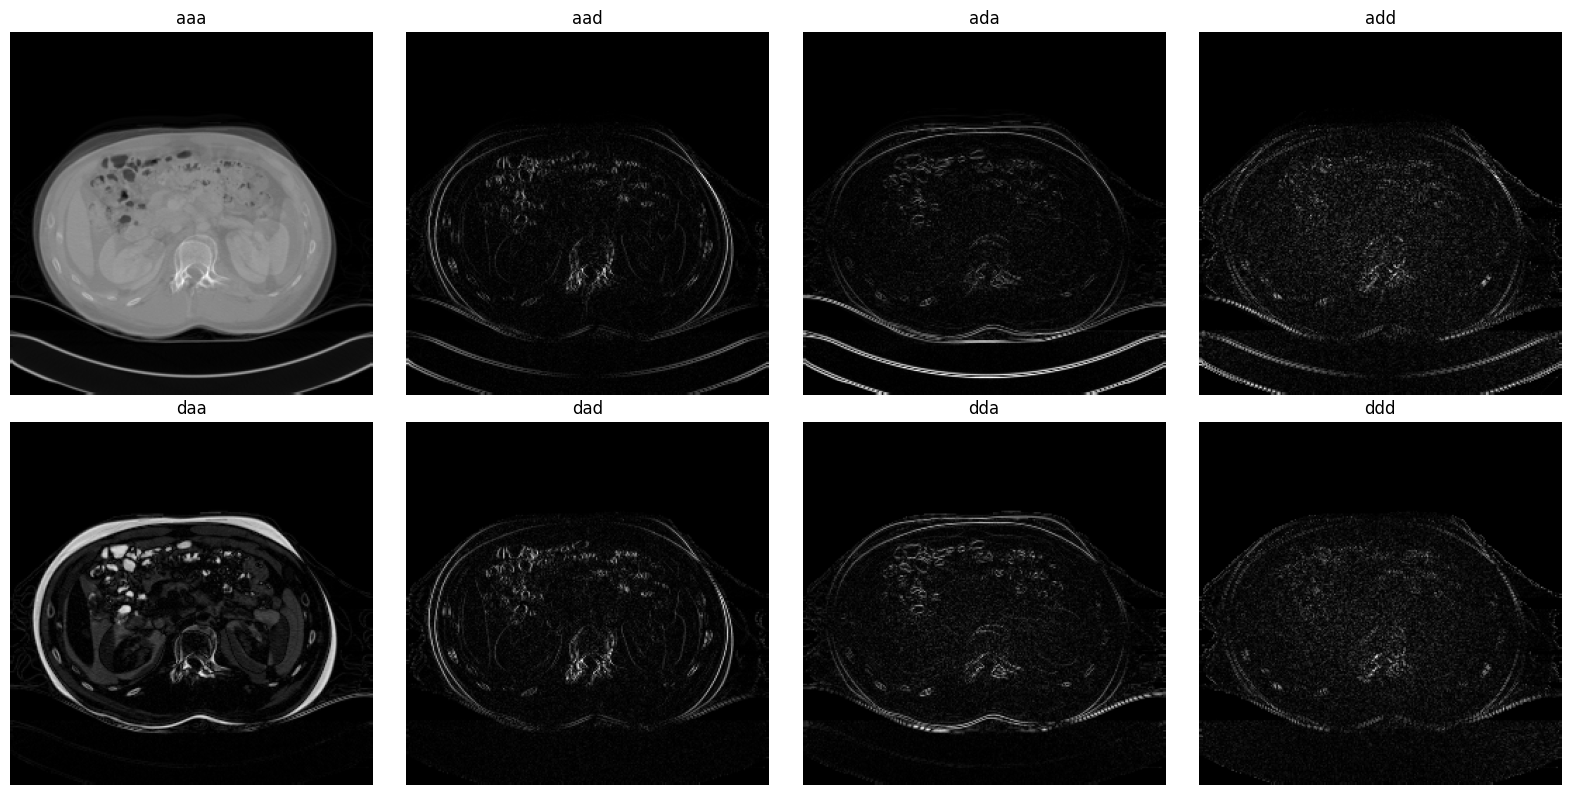

In [71]:
# Load a 3D image from the directory
def load_3d_image(dcm_dir):
    # Load all the images in the directory
    images = [pydicom.dcmread(os.path.join(dcm_dir, f)).pixel_array for f in os.listdir(dcm_dir)]
    # Stack the images to create a 3D image
    img = np.stack(images, axis=0)
    return img

def wavelet_3d(img):
    # 3D Discrete Wavelet Transform on the image and plot the approximation and detail results
    titles = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']
    coeffs3 = pywt.dwtn(img, 'bior1.3')

    # Take the absolute value of the coefficients to make them easier to visualize
    coeffs3 = {key: np.abs(coeffs3[key]) for key in coeffs3}

    # Create a composite image to visualize the coefficients
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, title in zip(axes.flatten(), titles):
        ax.imshow(coeffs3[title][coeffs3[title].shape[0] // 2], cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

img = load_3d_image(dcm_dir)
wavelet_3d(img)

### Multi-Level 3D DWT

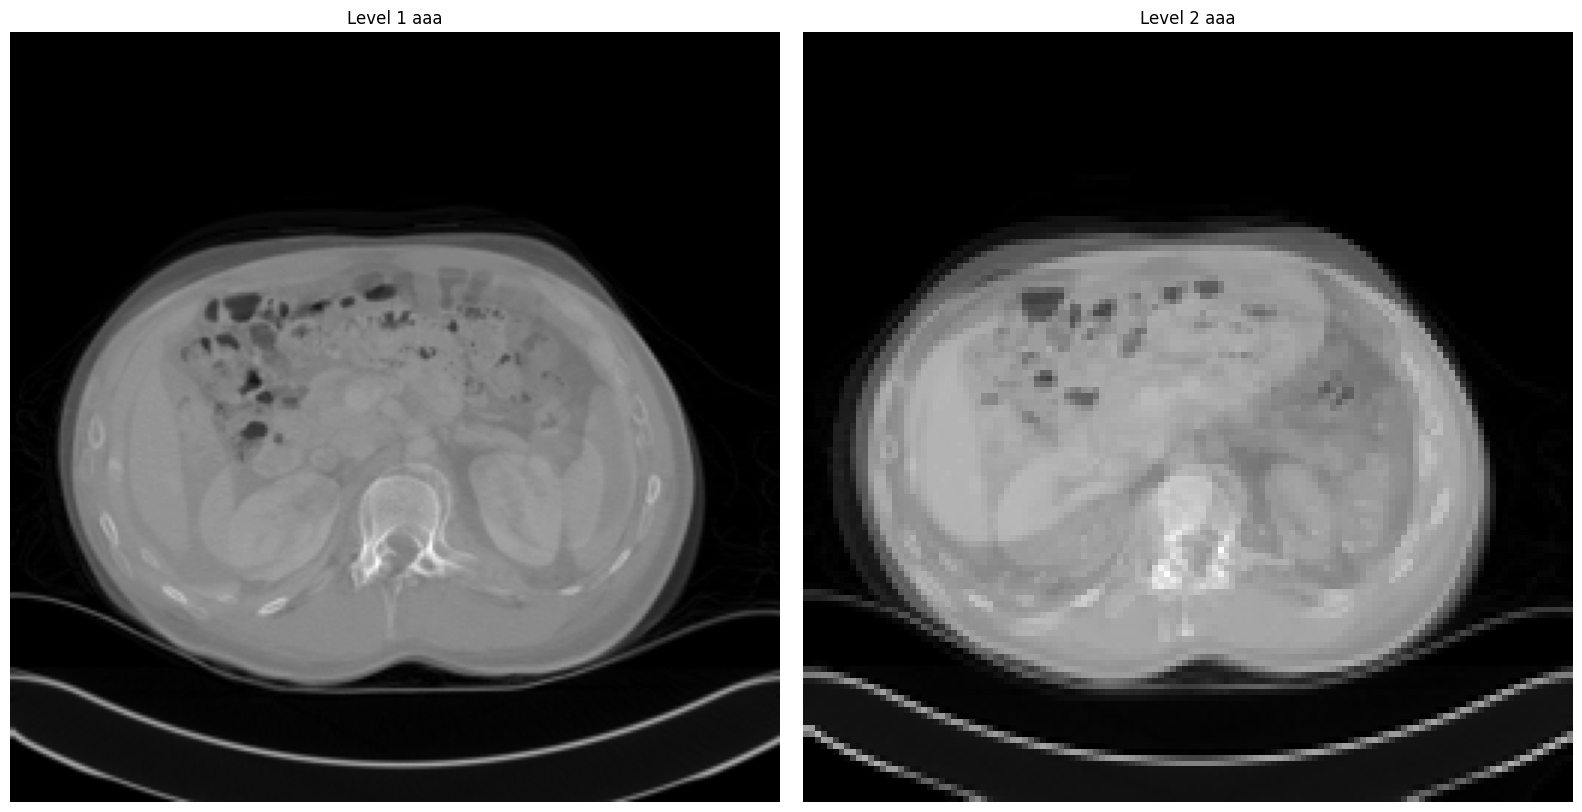

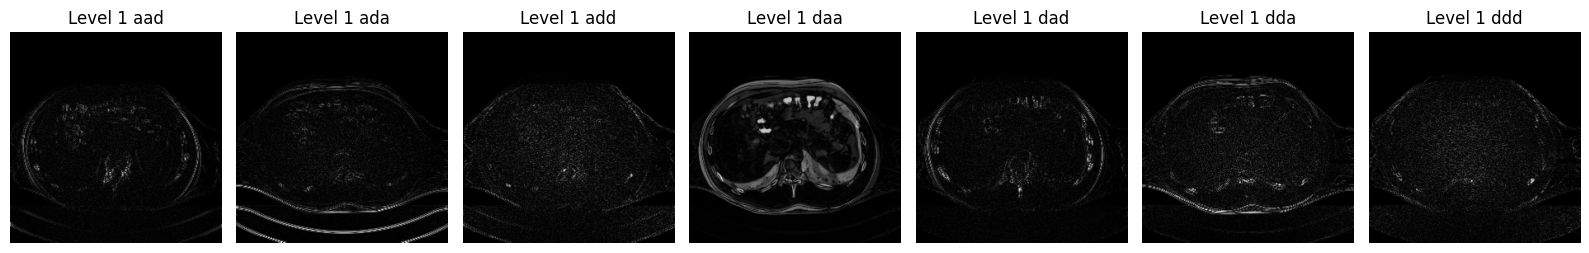

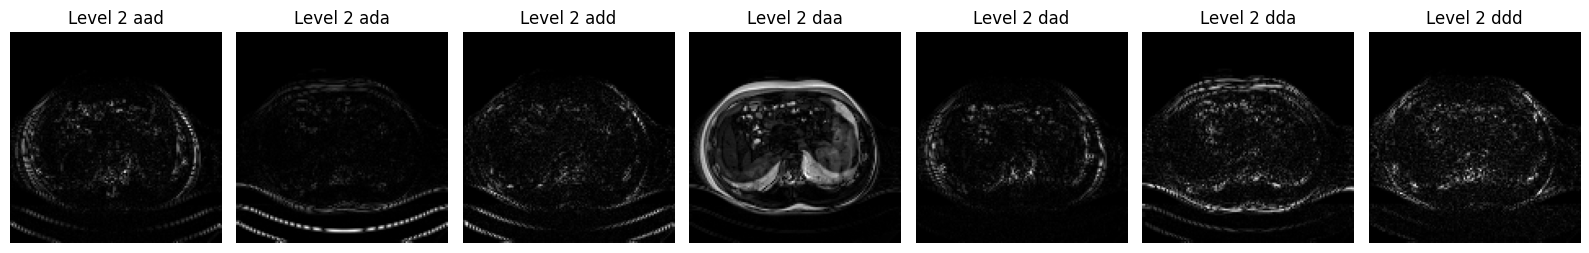

In [72]:
# Multi-level 3D DWT with visualization for all sub-bands
def wavelet_3d_multi(img, levels, wavelet='bior1.3'):
    LLL = []            # To store approximation coefficients at each level
    other_coeffs = []  # To store detail coefficients at each level

    for _ in range(levels):
        coeffs = pywt.wavedecn(img, wavelet=wavelet, level=1)
        
        # Store the approximation coefficients
        LLL.append(coeffs[0])
        
        # Collect the detail coefficients (horizontal, vertical, diagonal)
        other_coeffs.append(coeffs[1:])  # Collect detail coefficients as a list of dictionaries
        
        # Update img to be the approximation coefficients for the next level
        img = coeffs[0]  # Use the approximation coefficients for the next level

    # Take the abs of all coefficients for visualization
    LLL = [np.abs(level) for level in LLL]
    other_coeffs = [[{key: np.abs(arr) for key, arr in level.items()} for level in levels] for levels in other_coeffs]

    # Visualize the LLL coefficients
    fig, axes = plt.subplots(1, levels, figsize=(16, 8))
    for i, ax in enumerate(axes):
        ax.imshow(LLL[i][LLL[i].shape[0] // 2], cmap='gray')  # Show the middle slice for visualization
        ax.set_title(f'Level {i + 1} aaa')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot detail coefficients for each level
    for j in range(levels):
        detail_coeffs = other_coeffs[j]  # Get the detail coefficients for level j

        # Create subplots for detail coefficients
        num_detail_coeffs = len(detail_coeffs[0])  # Get the number of detail coefficients
        fig, axes = plt.subplots(1, num_detail_coeffs, figsize=(16, 8))
        
        # If there's only one detail coefficient, wrap the axes in a list
        if num_detail_coeffs == 1:
            axes = [axes]
        
        # Loop through each detail coefficient
        for i, key in enumerate(detail_coeffs[0].keys()):  # Access keys from the first dictionary
            detail_img = detail_coeffs[0][key]  # Get the detail coefficient array
            axes[i].imshow(detail_img[detail_img.shape[0] // 2], cmap='gray')  # Show the middle slice
            axes[i].set_title(f'Level {j + 1} {key}')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()


img = load_3d_image(dcm_dir)

wave = 'db2'
wavelet_3d_multi(img, levels=2, wavelet=wave)



## Get Wavelet Coefficients

In [73]:
def print_wavelet_filters(wavelet_name):
    """
    Print the low and high pass filter coefficients for a given wavelet.

    Parameters:
    wavelet_name (str): The name of the wavelet (e.g., 'db1', 'db2', 'db3', 'db4').
    """
    try:
        wavelet = pywt.Wavelet(wavelet_name)
        low_pass_filter = wavelet.dec_lo
        high_pass_filter = wavelet.dec_hi
        # Print the low and high pass filter coefficients
        print(f"{wavelet_name} low: {low_pass_filter}")
        print(f"{wavelet_name} high: {high_pass_filter}\n")
    except ValueError as e:
        print(f"Error: {e}. Please enter a valid wavelet name.")

# Example usage
wavelet_names = ['db1', 'db2', 'db3', 'db4']
for name in wavelet_names:
    print_wavelet_filters(name)


db1 low: [0.7071067811865476, 0.7071067811865476]
db1 high: [-0.7071067811865476, 0.7071067811865476]

db2 low: [-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416]
db2 high: [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]

db3 low: [0.03522629188570953, -0.08544127388202666, -0.13501102001025458, 0.45987750211849154, 0.8068915093110925, 0.33267055295008263]
db3 high: [-0.33267055295008263, 0.8068915093110925, -0.45987750211849154, -0.13501102001025458, 0.08544127388202666, 0.03522629188570953]

db4 low: [-0.010597401785069032, 0.0328830116668852, 0.030841381835560764, -0.18703481171909309, -0.027983769416859854, 0.6308807679298589, 0.7148465705529157, 0.2303778133088965]
db4 high: [-0.2303778133088965, 0.7148465705529157, -0.6308807679298589, -0.027983769416859854, 0.18703481171909309, 0.030841381835560764, -0.0328830116668852, -0.010597401785069032]

